>### import required packages

In [12]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,StratifiedKFold,KFold
from sklearn.metrics import accuracy_score,mean_squared_error,precision_score, recall_score, f1_score,confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc
from lightgbm import LGBMClassifier
import lightgbm as lgb
import seaborn as sns
import optuna
import time


>### get the data from yahoo finance

In [13]:
ticket = 'ISCTR.IS';
df = yf.Ticker(ticket).history(period='2y',interval='1h')[['Close', 'Open', 'High', 'Low', 'Volume']]
print(df)

                               Close       Open       High        Low  \
Datetime                                                                
2022-01-03 09:30:00+03:00   3.235566   3.240066   3.262566   3.226566   
2022-01-03 10:30:00+03:00   3.285067   3.240066   3.294067   3.235566   
2022-01-03 11:30:00+03:00   3.303067   3.280567   3.312067   3.276067   
2022-01-03 12:30:00+03:00   3.298567   3.303067   3.312067   3.289567   
2022-01-03 13:30:00+03:00   3.325567   3.303067   3.325567   3.294067   
...                              ...        ...        ...        ...   
2024-01-02 09:30:00+03:00  23.799999  23.820000  23.920000  23.620001   
2024-01-02 10:30:00+03:00  23.660000  23.799999  23.860001  23.639999   
2024-01-02 11:30:00+03:00  23.459999  23.639999  23.719999  23.440001   
2024-01-02 12:30:00+03:00  23.459999  23.480000  23.520000  23.379999   
2024-01-02 13:30:00+03:00  23.459999  23.480000  23.520000  23.420000   

                             Volume  
Datetime    

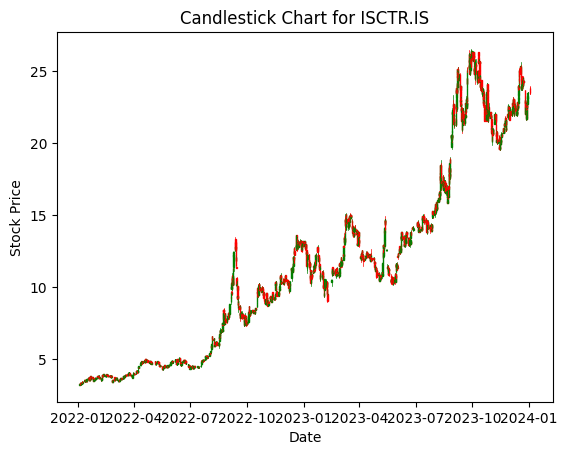

In [14]:
df['Date'] = mdates.date2num(df.index.to_pydatetime())
dates=df['Date']
# Create a candlestick chart
fig, ax = plt.subplots()
candlestick_ohlc(ax, df[['Date', 'Open', 'High', 'Low', 'Close']].values, width=1, colorup='g', colordown='r')

# Format x-axis as dates
ax.xaxis_date()

# Add title and labels
plt.title(f'Candlestick Chart for {ticket}')
plt.xlabel('Date')
plt.ylabel('Stock Price')

# Show the chart
plt.show()

>Boosting vs Decision tree

Boosting focuses on correcting the errors made by earlier models in the ensemble, adapting to the weaknesses of the previous models. Decision trees do not have this sequential, adaptive training process.

>### add indicators

In [15]:
# Exponential Moving Averages (EMA)
df['EMA_5'] = ta.ema(df['Close'], length=5)
df['EMA_8'] = ta.ema(df['Close'], length=8)
df['EMA_9'] = ta.ema(df['Close'], length=9)
df['EMA_13'] = ta.ema(df['Close'], length=13)
df['EMA_50'] = ta.ema(df['Close'], length=50)
df['EMA_200'] = ta.ema(df['Close'], length=200)
# Simple Moving Averages (SMA)
df['SMA_5'] = ta.sma(df['Close'], length=5)
df['SMA_8'] = ta.sma(df['Close'], length=8)
df['SMA_9'] = ta.sma(df['Close'], length=9)
df['SMA_13'] = ta.sma(df['Close'], length=13)
df['SMA_50'] = ta.sma(df['Close'], length=50)
df['SMA_200'] = ta.sma(df['Close'], length=200)
# Moving Average Convergence Divergence (MACD)
macd_result = ta.macd(df['Close'])
df = pd.concat([df, macd_result], axis=1)
# Relative Strength Index (RSI)
df['RSI'] = ta.rsi(df['Close'], length=14)

# Average Directional Index (ADX)
df['ADX'] = ta.adx(df['High'], df['Low'], df['Close'], length=14)["ADX_14"]
# Bollinger Bands
bollinger_result = ta.bbands(df['Close'])
# Select specific columns and assign them to the DataFrame
df[['Bollinger_Lower', 'Bollinger_Middle', 'Bollinger_Upper']] = bollinger_result[['BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0']]

df['Adj Close'] = df['Close']
df['Target'] = df['Adj Close'] - df['Open']
df['Target'] = df['Target'].shift(-1)
df['TargetClass'] = [1 if value > 0 else 0 for value in df['Target']]

print(df.isnull().sum())
#This line drops any rows that contain missing values (NaN) from the DataFrame df.
df.dropna(inplace=True)
#This line resets the index of the DataFrame df.
df.drop(['Date','Close','Target','Volume'],axis=1,inplace=True)
df.reset_index(inplace=True)

# Delete the first column
df = df.iloc[:, 1:]

sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(df)

X= data_set_scaled[:, :-1]
y= data_set_scaled[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Close                 0
Open                  0
High                  0
Low                   0
Volume                0
Date                  0
EMA_5                 4
EMA_8                 7
EMA_9                 8
EMA_13               12
EMA_50               49
EMA_200             199
SMA_5                 4
SMA_8                 7
SMA_9                 8
SMA_13               12
SMA_50               49
SMA_200             199
MACD_12_26_9         25
MACDh_12_26_9        33
MACDs_12_26_9        33
RSI                  14
ADX                  27
Bollinger_Lower       4
Bollinger_Middle      4
Bollinger_Upper       4
Adj Close             0
Target                1
TargetClass           0
dtype: int64


>GBM = Desicion Tree + Boosting + Gradient Descent
>LightGBM = GBM + GOSS + EFB
- EFB ise seyrek özellikleri birleştirip daha yoğun özellikler oluşturur. Bu da öğrenme sırasında karmaşıklığı azaltır. Bu işlemler de LGB’nin daha hızlı çalışmasını sağlamaktadır.
- GOSS, örnek veri sayısını azaltır. Verinin tümü yerine alt örneklem kümesi kullanılır.

- what is verbosity?

[I 2024-01-02 13:57:01,492] A new study created in memory with name: no-name-10eabd4c-69d7-46ce-b9e9-f46c9eb4fd50
[I 2024-01-02 13:57:02,225] Trial 0 finished with value: 0.41110571583482153 and parameters: {'boosting_type': 'dart', 'max_depth': 27, 'learning_rate': 0.016129120950231522, 'num_leaf': 38, 'colsample_bytree': 0.3320095470741218, 'min_data_in_leaf': 5, 'reg_alpha': 0.0001462826491655478, 'reg_lambda': 1.3514758042019383e-05}. Best is trial 0 with value: 0.41110571583482153.
[I 2024-01-02 13:57:02,790] Trial 1 finished with value: 0.23452079007322585 and parameters: {'boosting_type': 'gbdt', 'max_depth': 19, 'learning_rate': 0.004641455932957781, 'num_leaf': 40, 'colsample_bytree': 0.5021075585927088, 'min_data_in_leaf': 23, 'reg_alpha': 0.018486554893368364, 'reg_lambda': 0.00023066750256389384}. Best is trial 0 with value: 0.41110571583482153.
[I 2024-01-02 13:57:03,281] Trial 2 finished with value: 0.47360744991560144 and parameters: {'boosting_type': 'gbdt', 'max_depth'

Elapsed time: 32.75410270690918 seconds
Best hyperparameters: {'boosting_type': 'dart', 'max_depth': 13, 'learning_rate': 0.09624347426739369, 'num_leaf': 2, 'colsample_bytree': 0.33098517238144, 'min_data_in_leaf': 8, 'reg_alpha': 0.012686261203879909, 'reg_lambda': 0.01685212838038854}
Best F1 score: 0.5728889968975562
{'objective': 'binary', 'metric': 'binary_logloss', 'is_unbalance': True, 'boosting_type': 'dart', 'max_depth': 13, 'verbosity': 0, 'learning_rate': 0.09624347426739369, 'num_leaf': 2, 'colsample_bytree': 0.33098517238144, 'min_data_in_leaf': 8, 'reg_alpha': 0.012686261203879909, 'reg_lambda': 0.01685212838038854}
after optimizing: 
Accuracy: 0.47447073474470736
Precision: 0.4549
Recall: 0.8532
F1 Score: 0.5934


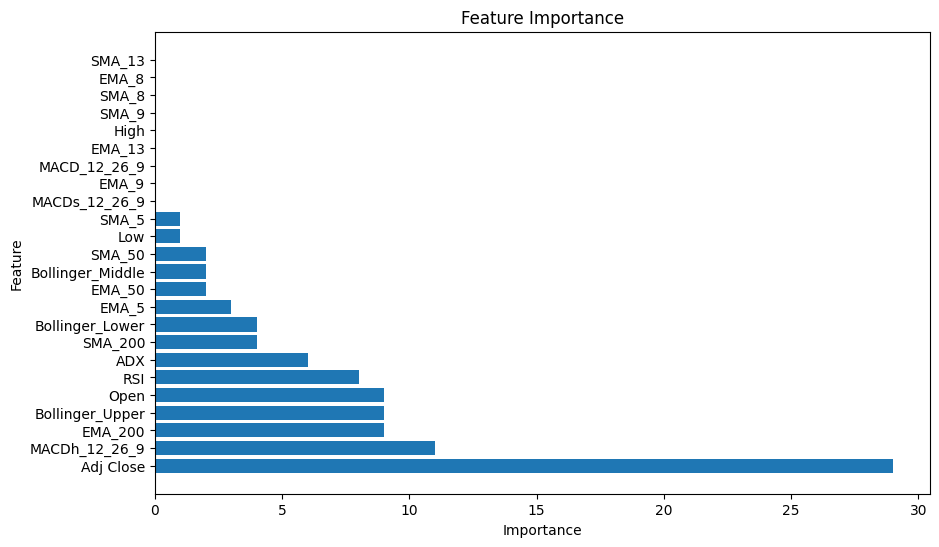

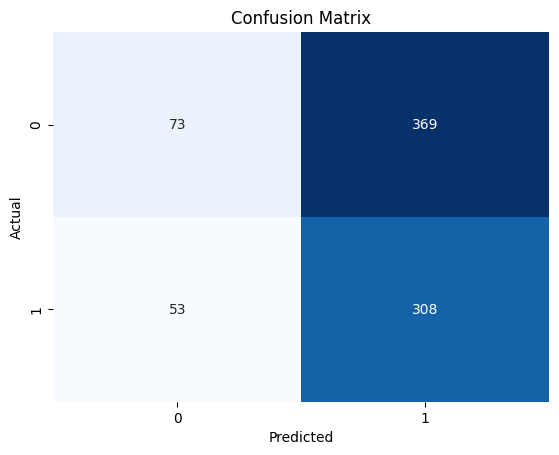

In [16]:


def objective(trial):
    params = {
        'objective': 'binary',
        "metric": 'binary_logloss',
        'is_unbalance': True,
        'boosting_type':  trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'max_depth': trial.suggest_int('max_depth',10,50),
        "verbosity": -1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaf": trial.suggest_int("num_leaf", 2, 2**6),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 2**5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 10, log=True),  # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 10, log=True),  # L2 regularization
    }
    # Train and evaluate the model using cross-validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []
    for train_index, valid_index in kf.split(X_train, y_train):
        X_tr, X_val = X_train[train_index], X_train[valid_index]
        y_tr, y_val = y_train[train_index], y_train[valid_index]

        # Train the model on the training fold
        model = lgb.train(params, lgb.Dataset(X_tr, label=y_tr))

        # Evaluate on the validation fold
        y_pred = model.predict(X_val, num_iteration=model.best_iteration)
        y_pred_binary = (y_pred > 0.5).astype(int)
        f1 = f1_score(y_val, y_pred_binary)

        cv_scores.append(f1)

    # Return the average F1 score across folds
    return sum(cv_scores) / len(cv_scores)

study = optuna.create_study(direction='maximize',sampler=optuna.samplers.CmaEsSampler(warn_independent_sampling=False))


start_time = time.time()
study.optimize(objective, n_trials=100)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


print('Best hyperparameters:', study.best_params)
print('Best F1 score:', study.best_value)

params = {
    'objective': 'binary',
    "metric": 'binary_logloss',
    'is_unbalance': True,
    'boosting_type': study.best_params["boosting_type"],
    'max_depth': study.best_params["max_depth"],
    "verbosity": 0,
    "learning_rate": study.best_params["learning_rate"],
    "num_leaf": study.best_params["num_leaf"],
    "colsample_bytree": study.best_params["colsample_bytree"],
    "min_data_in_leaf": study.best_params["min_data_in_leaf"],
    'reg_alpha': study.best_params["reg_alpha"],
    'reg_lambda': study.best_params["reg_lambda"]
}
print(params)
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

bst = lgb.train(params, train_data,valid_sets=[train_data, val_data])
y_pred = bst.predict(X_test)
y_pred_labels = (y_pred >= 0.5).astype(int)


#model evaluation metrices
print("after optimizing: ")
accuracy = accuracy_score(y_test, y_pred_labels)
print(f"Accuracy: {accuracy}")
precision = precision_score(y_test, y_pred_labels)
print(f'Precision: {precision:.4f}')
recall = recall_score(y_test, y_pred_labels)
print(f'Recall: {recall:.4f}')
f1 = f1_score(y_test, y_pred_labels)
print(f'F1 Score: {f1:.4f}')

# FEATURE IMPORTANCE
features = (df.columns.tolist())[:-1]

# Get feature importance from the trained LightGBM model
feature_importance = bst.feature_importance(importance_type='split')  # 'split' or 'gain'

# Create a DataFrame to store feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()


# Assuming y_pred_labels is your predicted labels
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Plotting confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Reconstruct model with most important features(would be first 15)

In [17]:

top_features = feature_importance_df.head(8)['Feature'].tolist()
df_X = df[top_features].copy()
df_y = df["TargetClass"].values

sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled_TOPFEATURES = sc.fit_transform(df_X)

X_train, X_test, y_train, y_test = train_test_split(data_set_scaled_TOPFEATURES, df_y, test_size=0.2, random_state=42)


In [18]:
model = LGBMClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
f1 = f1_score(y_test, predictions)
print(f"F1 score before optimizing : {f1}")


[LightGBM] [Info] Number of positive: 1459, number of negative: 1751
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 3210, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.454517 -> initscore=-0.182436
[LightGBM] [Info] Start training from score -0.182436
F1 score before optimizing : 0.45535714285714285


## Objective Function

In [19]:
def objective(trial):
    params = {
        'objective': 'binary',
        "metric": 'binary_logloss',
        'is_unbalance': True,
        'boosting_type':  trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'max_depth': trial.suggest_int('max_depth',10,50),
        "verbosity": -1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaf": trial.suggest_int("num_leaf", 2, 2**6),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 2**5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 10, log=True),  # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 10, log=True),  # L2 regularization
    }
    # Train and evaluate the model using cross-validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []
    for train_index, valid_index in kf.split(X_train, y_train):
        X_tr, X_val = X_train[train_index], X_train[valid_index]
        y_tr, y_val = y_train[train_index], y_train[valid_index]

        # Train the model on the training fold
        model = lgb.train(params, lgb.Dataset(X_tr, label=y_tr))

        # Evaluate on the validation fold
        y_pred = model.predict(X_val, num_iteration=model.best_iteration)
        y_pred_binary = (y_pred > 0.5).astype(int)
        f1 = f1_score(y_val, y_pred_binary)

        cv_scores.append(f1)

    # Return the average F1 score across folds
    return sum(cv_scores) / len(cv_scores)


[I 2024-01-02 13:57:34,610] A new study created in memory with name: no-name-71631d5d-44ea-4efc-984a-86c72c60b5c2
[I 2024-01-02 13:57:34,871] Trial 0 finished with value: 0.05826332238748981 and parameters: {'boosting_type': 'gbdt', 'max_depth': 33, 'learning_rate': 0.003618841293990134, 'num_leaf': 20, 'colsample_bytree': 0.50983582938024, 'min_data_in_leaf': 23, 'reg_alpha': 0.02185045882372011, 'reg_lambda': 0.0004013886248095612}. Best is trial 0 with value: 0.05826332238748981.
[I 2024-01-02 13:57:35,301] Trial 1 finished with value: 0.46556108422117504 and parameters: {'boosting_type': 'gbdt', 'max_depth': 26, 'learning_rate': 0.014997057157206886, 'num_leaf': 38, 'colsample_bytree': 0.573875650223732, 'min_data_in_leaf': 20, 'reg_alpha': 0.006696964537782091, 'reg_lambda': 0.004688993128158644}. Best is trial 1 with value: 0.46556108422117504.
[I 2024-01-02 13:57:35,639] Trial 2 finished with value: 0.4868293658028757 and parameters: {'boosting_type': 'gbdt', 'max_depth': 28, 'l

Elapsed time: 64.49835085868835 seconds
Best hyperparameters: {'boosting_type': 'dart', 'max_depth': 20, 'learning_rate': 0.07147315298427057, 'num_leaf': 5, 'colsample_bytree': 0.626467719153532, 'min_data_in_leaf': 29, 'reg_alpha': 0.13141013471592095, 'reg_lambda': 0.00048193223058303034}
Best F1 score: 0.5265102893692055
{'objective': 'binary', 'metric': 'binary_logloss', 'is_unbalance': True, 'boosting_type': 'dart', 'max_depth': 20, 'verbosity': 0, 'learning_rate': 0.07147315298427057, 'num_leaf': 5, 'colsample_bytree': 0.626467719153532, 'min_data_in_leaf': 29, 'reg_alpha': 0.13141013471592095, 'reg_lambda': 0.00048193223058303034}
Accuracy: 0.5056039850560399
Precision: 0.4660
Recall: 0.6842
F1 Score: 0.5544


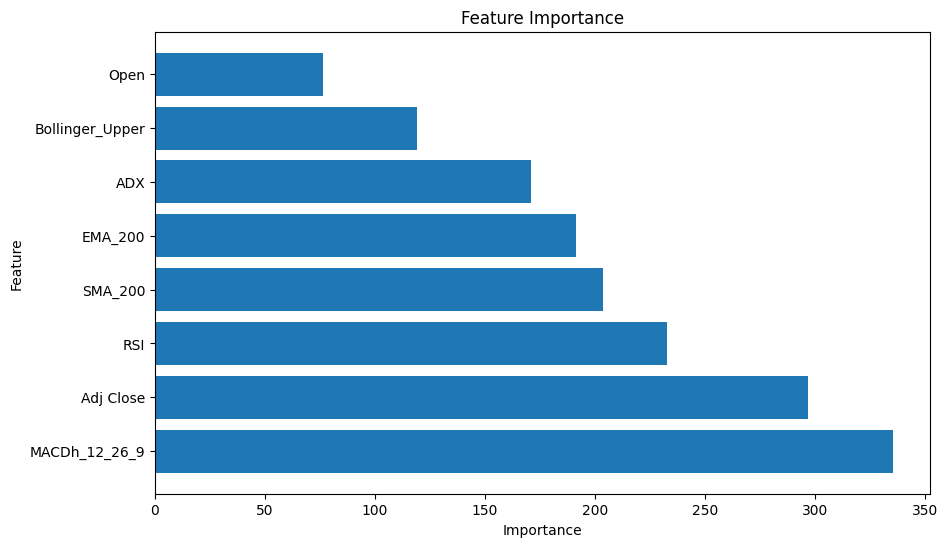

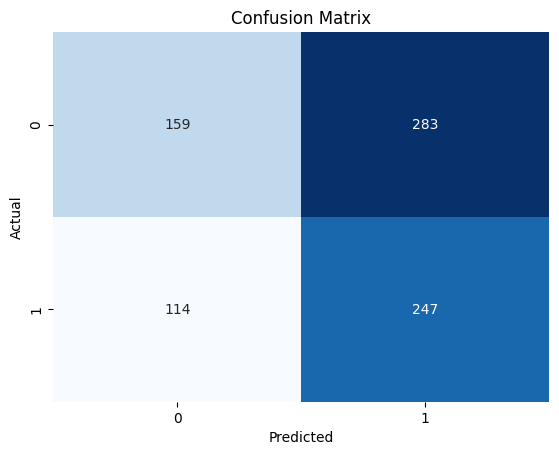

In [20]:

study = optuna.create_study(direction='maximize',sampler=optuna.samplers.CmaEsSampler(warn_independent_sampling=False))
start_time = time.time()
study.optimize(objective, n_trials=200)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")
optuna.visualization.plot_optimization_history(study)
print('Best hyperparameters:', study.best_params)
print('Best F1 score:', study.best_value)

params = {
    'objective': 'binary',
    "metric": 'binary_logloss',
    'is_unbalance': True,
    'boosting_type': study.best_params["boosting_type"],
    'max_depth': study.best_params["max_depth"],
    "verbosity": 0,
    "learning_rate": study.best_params["learning_rate"],
    "num_leaf": study.best_params["num_leaf"],
    "colsample_bytree": study.best_params["colsample_bytree"],
    "min_data_in_leaf": study.best_params["min_data_in_leaf"],
    'reg_alpha': study.best_params["reg_alpha"],
    'reg_lambda': study.best_params["reg_lambda"]
}
print(params)
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

bst = lgb.train(params, train_data,valid_sets=[train_data, val_data])
y_pred = bst.predict(X_test)
y_pred_labels = (y_pred >= 0.5).astype(int)


#model evaluation metrices

accuracy = accuracy_score(y_test, y_pred_labels)
print(f"Accuracy: {accuracy}")
precision = precision_score(y_test, y_pred_labels)
print(f'Precision: {precision:.4f}')
recall = recall_score(y_test, y_pred_labels)
print(f'Recall: {recall:.4f}')
f1 = f1_score(y_test, y_pred_labels)
print(f'F1 Score: {f1:.4f}')

# FEATURE IMPORTANCE
features = (df_X.columns.tolist())

# Get feature importance from the trained LightGBM model
feature_importance = bst.feature_importance(importance_type='gain')  # 'split' or 'gain'

# Create a DataFrame to store feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()


# Assuming y_pred_labels is your predicted labels
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Plotting confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [21]:
optuna.visualization.plot_optimization_history(study)
optuna.visualization.plot_param_importances(study)

In [22]:
#4213 10:30
last_data = df_X[-1:]
pred= bst.predict(last_data)
print(pred)

[0.22815839]


C:\Users\Alp Bugra Toker\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightgbm\basic.py:599: UserWarning:

Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.

